In [1]:
import pandas as pd
import numpy as np
import sys
import os
import geopandas as gpd
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import log_loss


os.chdir('..')
from models.model5 import model as model5

from model_utils.utils import cat_int_enc, gen_labels, conv_cat_num, conv_cat_str, load_k_train, stratify, append_test_train, split_test_train
from model_utils.evaluator import gen_eval, print_eval 

In [2]:
def gen_centroids(df, gdf):
    gdf['lon'] = gdf.centroid.x
    gdf['lat'] = gdf.centroid.y

    dfm = df.merge(
        gdf,
        left_on=['Division', 'District', 'Upazila', 'Union'],
        right_on=['div', 'dis', 'upa', 'uni'],
        how='left',
    )
    dfm.drop(['area'], axis=1, inplace=True, errors='ignore')

    return dfm['lon'], dfm['lat']

In [3]:
def ohe_col(df, cols):
    return pd.get_dummies(data=df, columns=cols)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207420 entries, 2 to 173719
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Division  207420 non-null  object 
 1   District  207420 non-null  object 
 2   Upazila   207420 non-null  object 
 3   Union     207420 non-null  object 
 4   Mouza     207420 non-null  object 
 5   Depth     207420 non-null  float64
 6   Arsenic   207420 non-null  float64
 7   Label     207420 non-null  object 
 8   tid       207420 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 15.8+ MB


/tmp/ipykernel_123752/2589200396.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/tmp/ipykernel_123752/2589200396.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


<class 'pandas.core.frame.DataFrame'>
Int64Index: 207420 entries, 2 to 173719
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Depth    207420 non-null  float64
 1   Arsenic  207420 non-null  float64
 2   Label    207420 non-null  object 
 3   tid      207420 non-null  int64  
 4   lon      207420 non-null  float64
 5   lat      207420 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 11.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 207420 entries, 2 to 173719
Columns: 4860 entries, Depth to lon_92.25137599882451
dtypes: float64(2), int64(1), object(1), uint8(4856)
memory usage: 968.5+ MB
Iteration 1, loss = 0.48693714


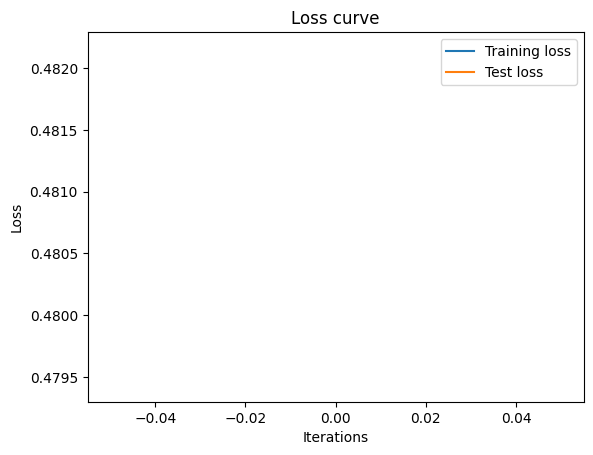

Iteration 2, loss = 0.48223811


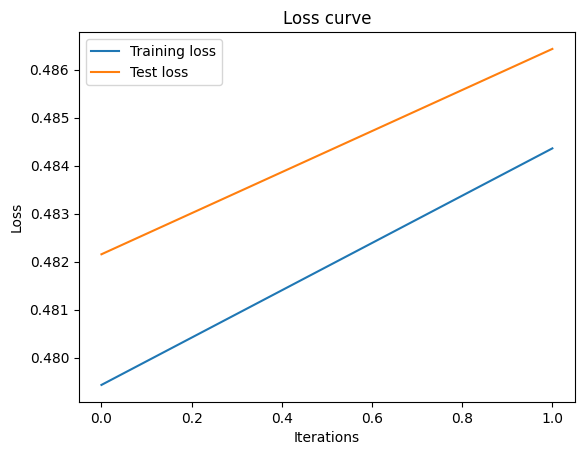

Iteration 3, loss = 0.48127996


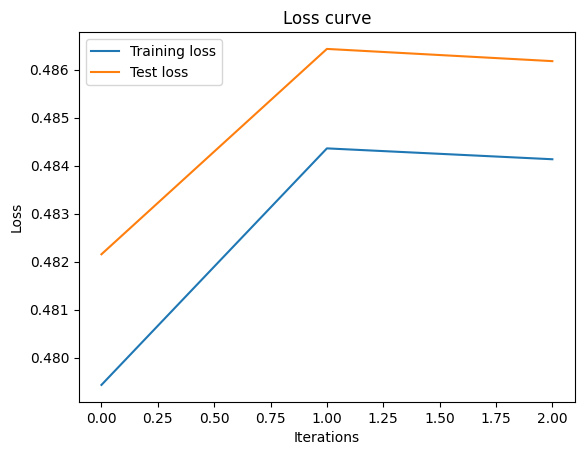

Iteration 4, loss = 0.48052434


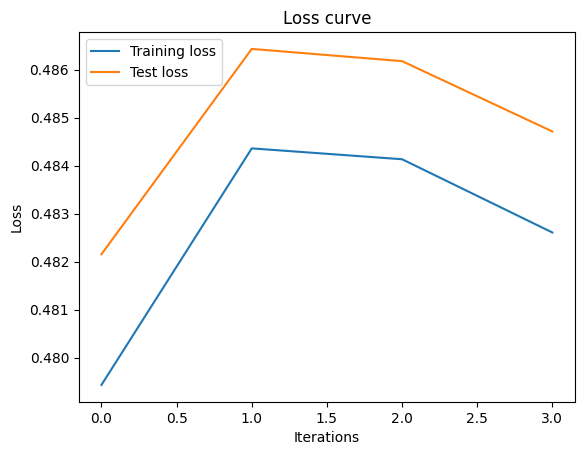

Iteration 5, loss = 0.47994394


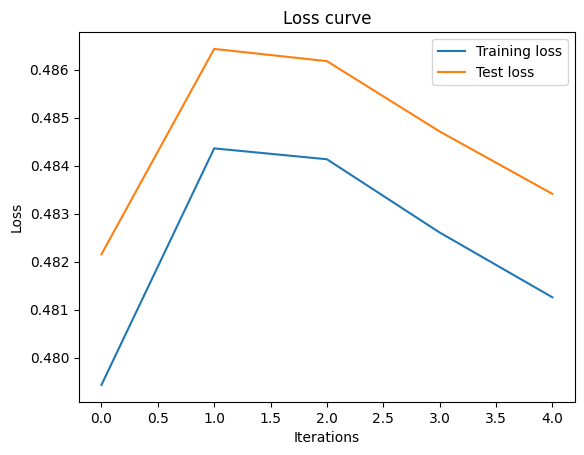

Iteration 6, loss = 0.47935444


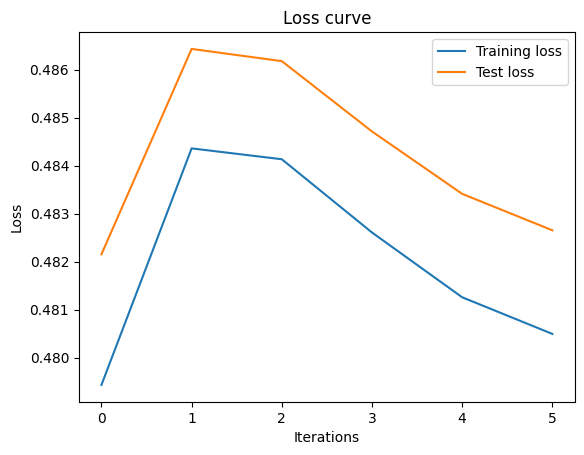

Iteration 7, loss = 0.47880509


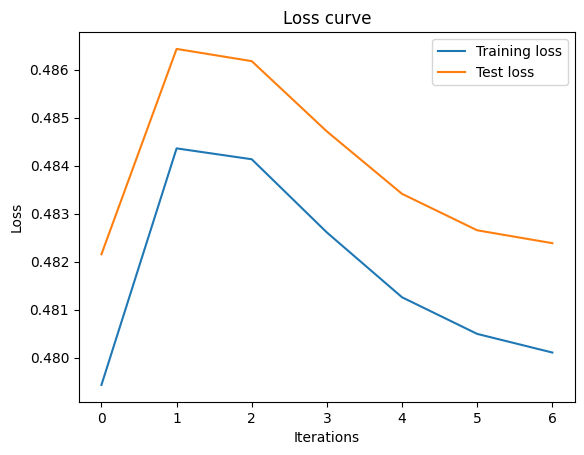

Iteration 8, loss = 0.47822458


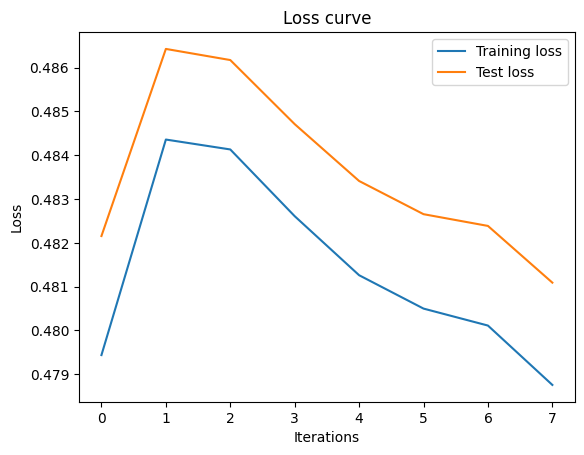

Iteration 9, loss = 0.47759134


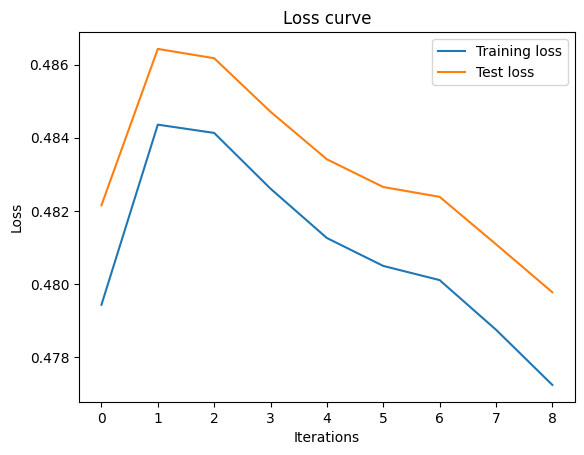

Iteration 10, loss = 0.47704666


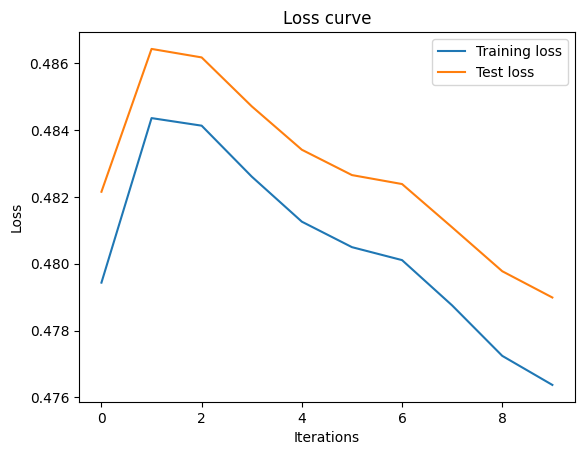

Iteration 11, loss = 0.47669329


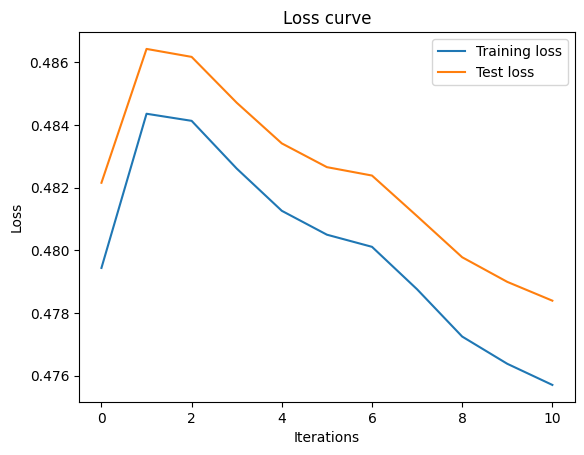

Iteration 12, loss = 0.47641654


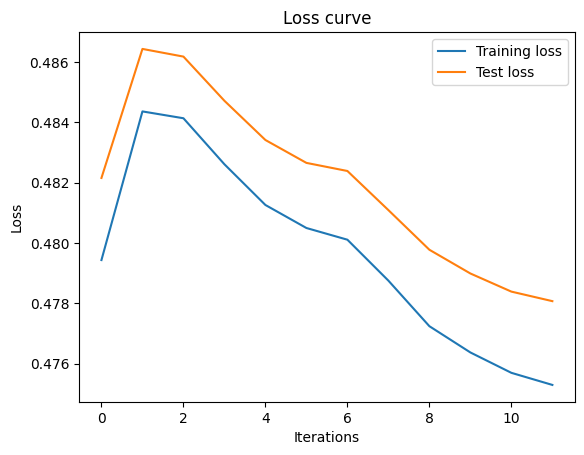

Iteration 13, loss = 0.47615012


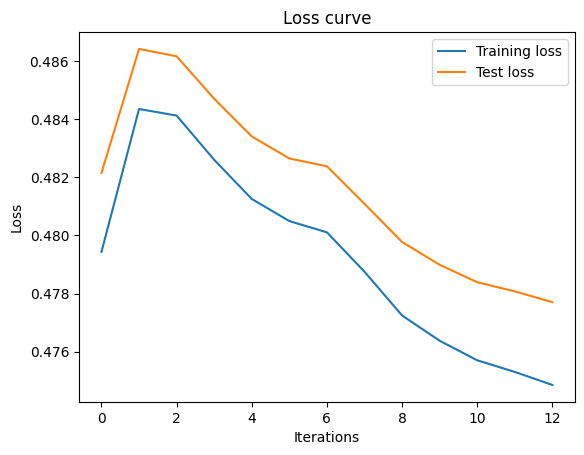

Iteration 14, loss = 0.47600760


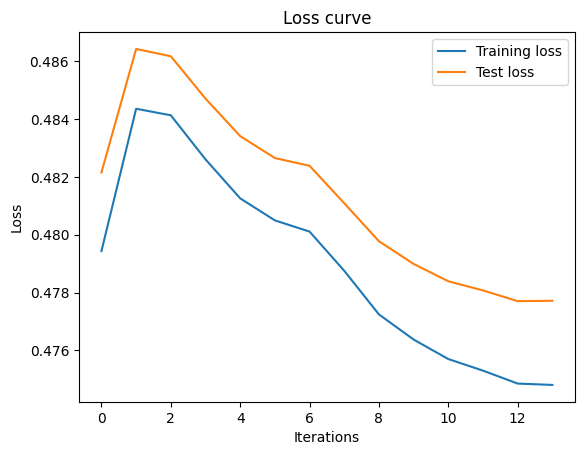

Iteration 15, loss = 0.47586381


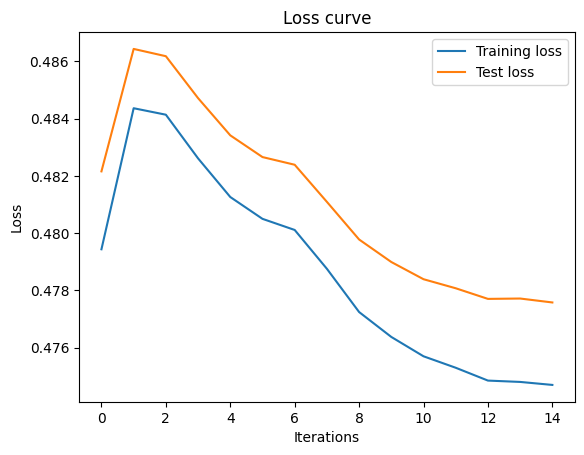

Iteration 16, loss = 0.47566892


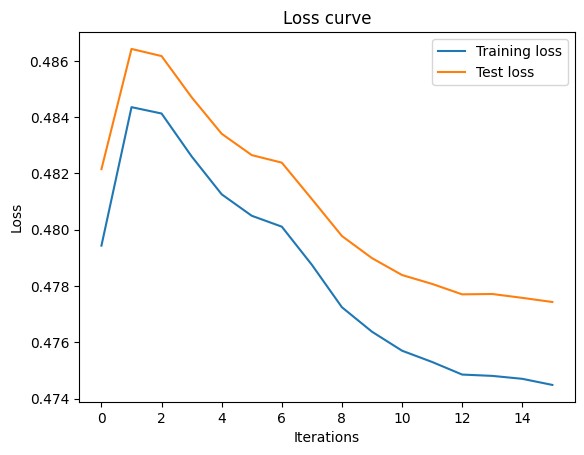

Iteration 17, loss = 0.47549818


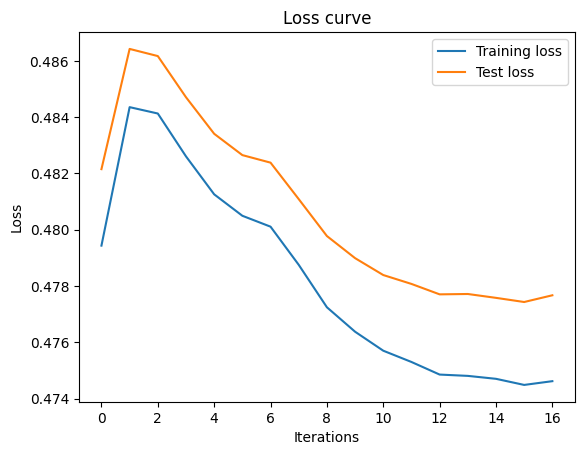

Iteration 18, loss = 0.47531618


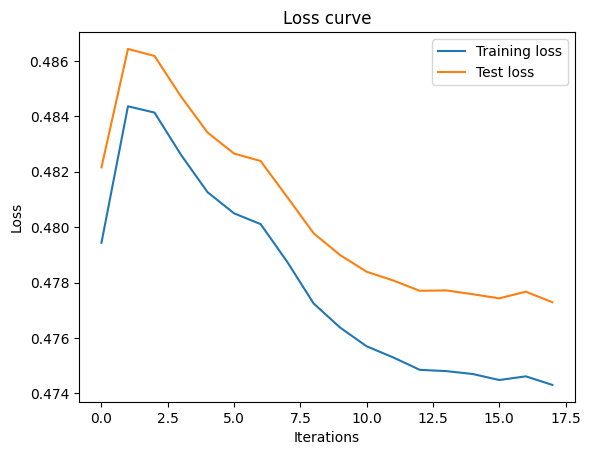

Iteration 19, loss = 0.47513864


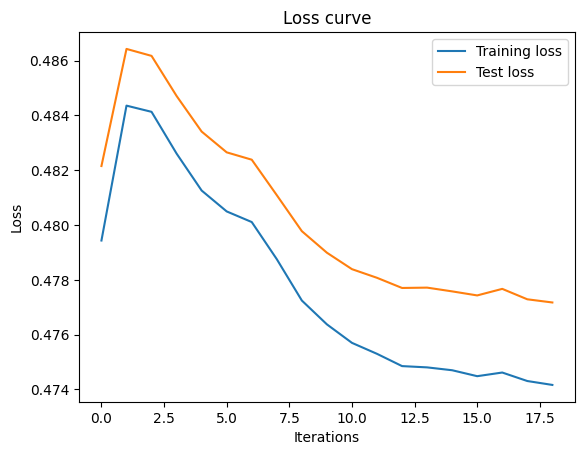

Iteration 20, loss = 0.47489027


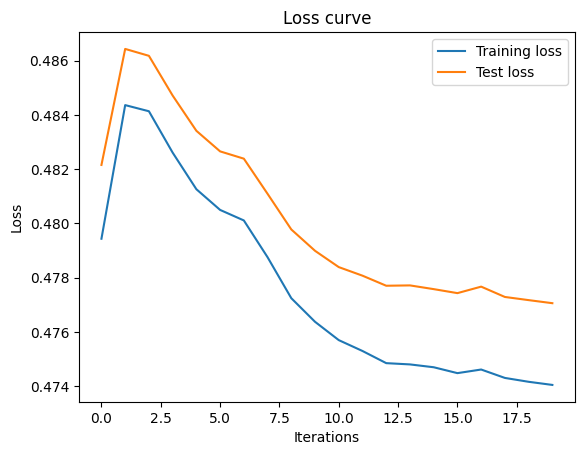

Iteration 21, loss = 0.47472723


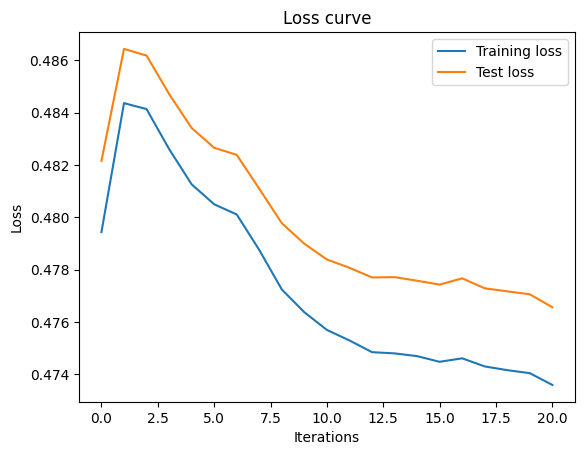

Iteration 22, loss = 0.47457931


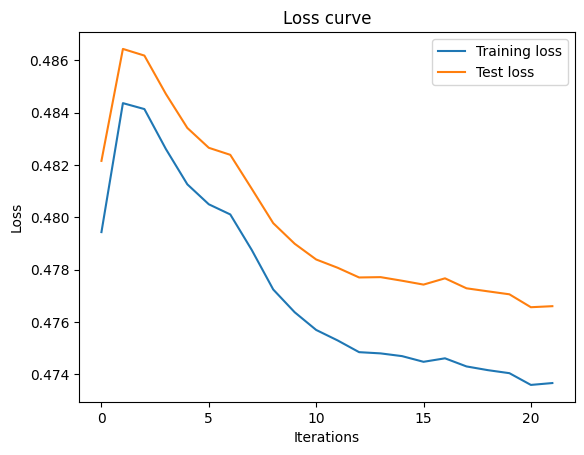

Iteration 23, loss = 0.47419837


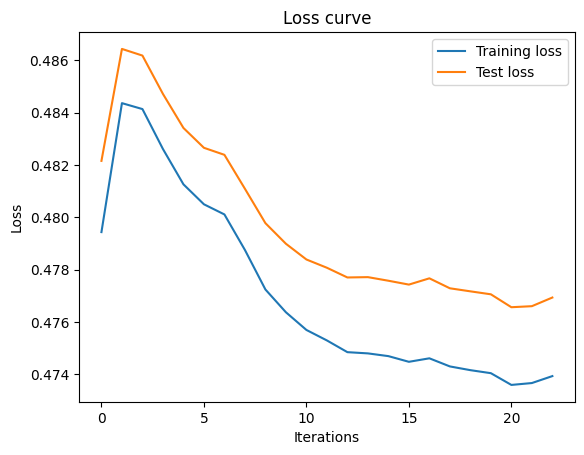

Iteration 24, loss = 0.47394556


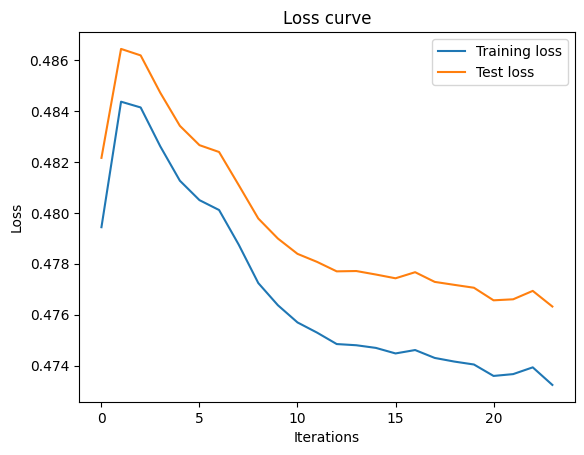

Iteration 25, loss = 0.47370542


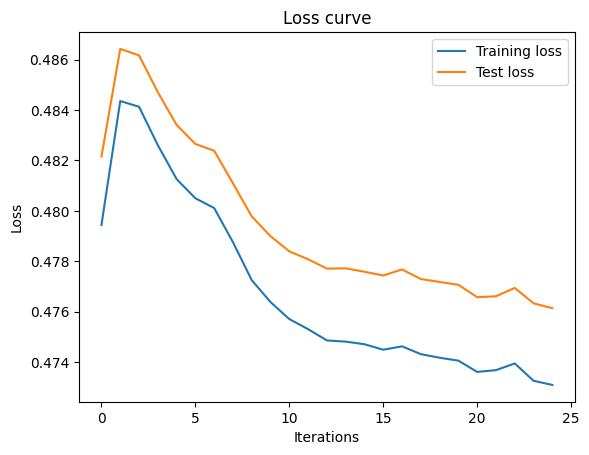

Iteration 26, loss = 0.47357659


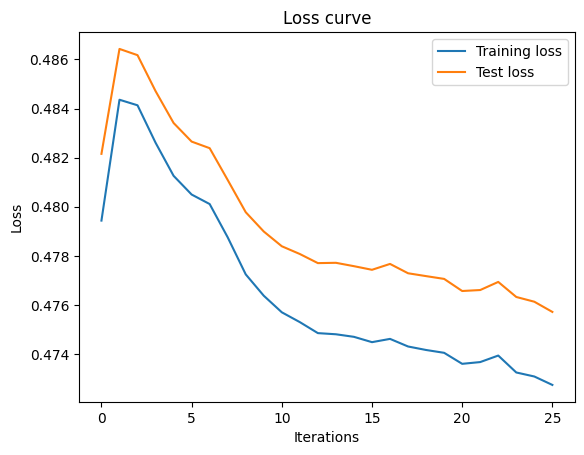

Iteration 27, loss = 0.47343080


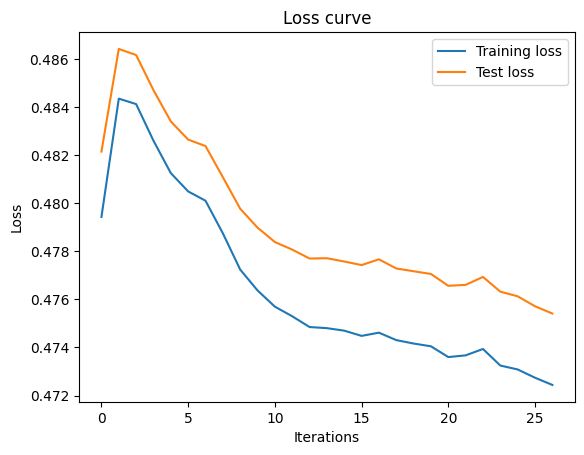

Iteration 28, loss = 0.47335063


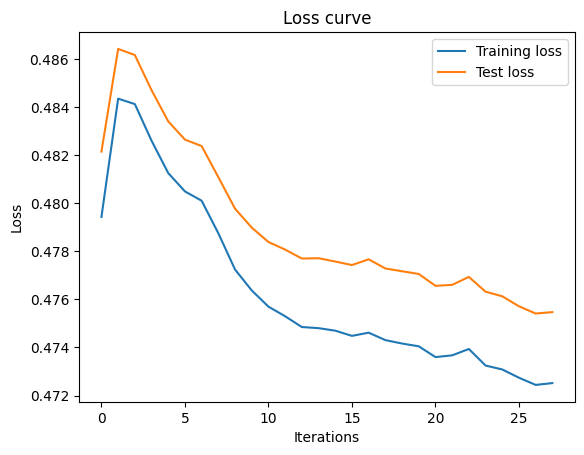

Iteration 29, loss = 0.47331943


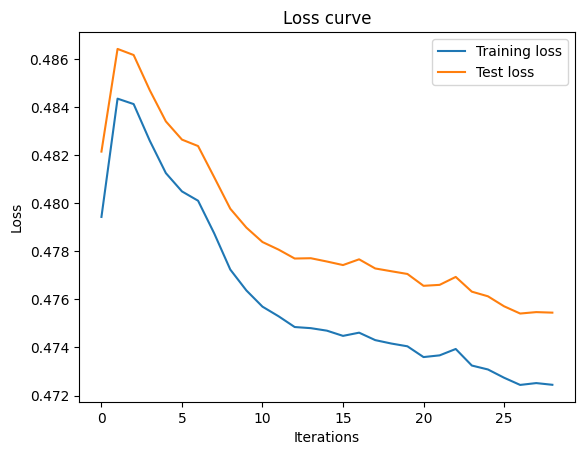

Iteration 30, loss = 0.47322180


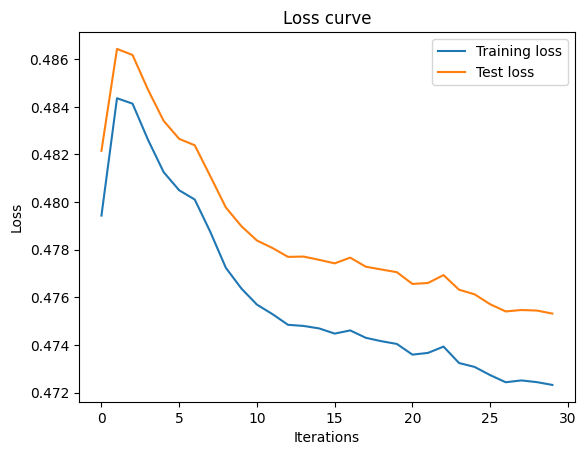

In [4]:
def gen_predictions(train_df, test_df):
    train = train_df.copy()
    test = test_df.copy()
    gdf = gpd.read_file('./geodata/mou/mou-c005-s010-vw-pr.geojson')

    tt_df = append_test_train(test, train)
    tt_df = tt_df[tt_df['Division'] == 'Chittagong']
    tt_df.info()
    tt_df['lon'], tt_df['lat'] = gen_centroids(tt_df, gdf)
    tt_df = tt_df.drop(
        columns=[
            'Division',
            'District',
            'Union',
            'Upazila',
            'Mouza'
        ]
    )
    
    print('==========')
    tt_df.info()
    test, train = split_test_train(tt_df)

    conv_cat_num(train, 'Label')
    conv_cat_num(test, 'Label')

    cat_int_enc(train)
    cat_int_enc(test)

    stratify(test)
    stratify(train)
    
    tt_df = ohe_col(tt_df, ['lat'])
    tt_df = ohe_col(tt_df, ['lon'])
    tt_df.info()
    

    train_X = train.drop(['Arsenic', 'Label'], axis='columns')
    train_y = train['Label']

    test_X = test.drop(['Arsenic', 'Label'], axis='columns')

    tt_df = append_test_train(test, train)
    cat_int_enc(tt_df)
    tt_df = pd.DataFrame(MinMaxScaler().fit_transform(tt_df), columns=tt_df.columns)

    te_div, tr_div = split_test_train(tt_df)

    X_train = tr_div.drop(
        ['Arsenic', 'Label', 'Prediction', 'Strata'], 
        axis='columns',
        errors='ignore'
    )

    y_train = tr_div['Label']
    X_test = te_div.drop(
        ['Arsenic', 'Label', 'Strata'],
        axis='columns'
    )
    y_test = te_div['Label']

    clf = MLPClassifier(
        solver='adam',
        alpha=0.0001,
        hidden_layer_sizes=(2000, 1000, 100),
        learning_rate='adaptive',
        random_state=99,
        max_iter=30,
        verbose=True,
    )

    test_loss = [] 
    train_loss = []
    for i in range(clf.max_iter):
        # train
        clf.partial_fit(X_train, y_train, classes=np.unique(y_train))
        y_train_pred = clf.predict_proba(X_train)
        train_loss.append(log_loss(y_train, y_train_pred))

        # test
        y_test_pred = clf.predict_proba(X_test)
        test_loss.append(log_loss(y_test, y_test_pred))

        plt.plot(train_loss, label='Training loss')
        plt.plot(test_loss, label='Test loss')
        plt.title('Loss curve')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

def big_clf(
  test_src='./well_data/k1.csv',
  k_fold=1,
):
    train_df = load_k_train(k_fold)
    test_df = pd.read_csv(test_src) 

    train_df['Label'] = gen_labels(train_df)
    test_df['Label'] = gen_labels(test_df)

    gen_predictions(train_df, test_df)

big_clf()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207420 entries, 2 to 173719
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Division  207420 non-null  object 
 1   District  207420 non-null  object 
 2   Upazila   207420 non-null  object 
 3   Union     207420 non-null  object 
 4   Mouza     207420 non-null  object 
 5   Depth     207420 non-null  float64
 6   Arsenic   207420 non-null  float64
 7   Label     207420 non-null  object 
 8   tid       207420 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 15.8+ MB


/tmp/ipykernel_123752/2589200396.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/tmp/ipykernel_123752/2589200396.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


<class 'pandas.core.frame.DataFrame'>
Int64Index: 207420 entries, 2 to 173719
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Depth    207420 non-null  float64
 1   Arsenic  207420 non-null  float64
 2   Label    207420 non-null  object 
 3   tid      207420 non-null  int64  
 4   lon      207420 non-null  float64
 5   lat      207420 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 11.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 207420 entries, 2 to 173719
Columns: 4860 entries, Depth to lon_92.25137599882451
dtypes: float64(2), int64(1), object(1), uint8(4856)
memory usage: 968.5+ MB
Iteration 1, loss = 0.53030690


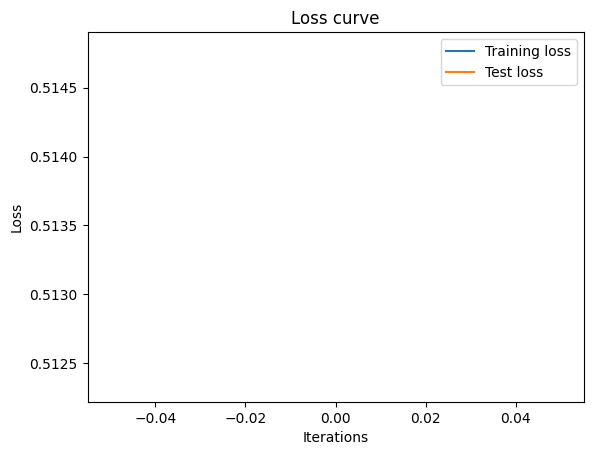

Iteration 2, loss = 0.50306460


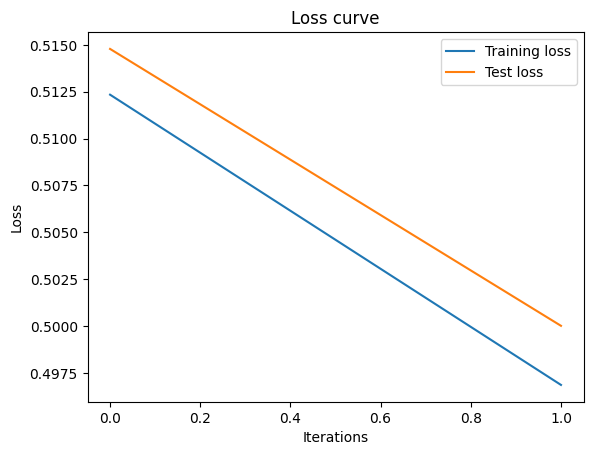

Iteration 3, loss = 0.49476994


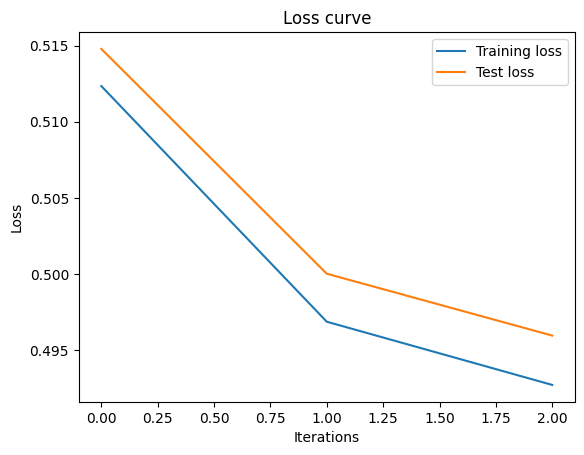

Iteration 4, loss = 0.49173213


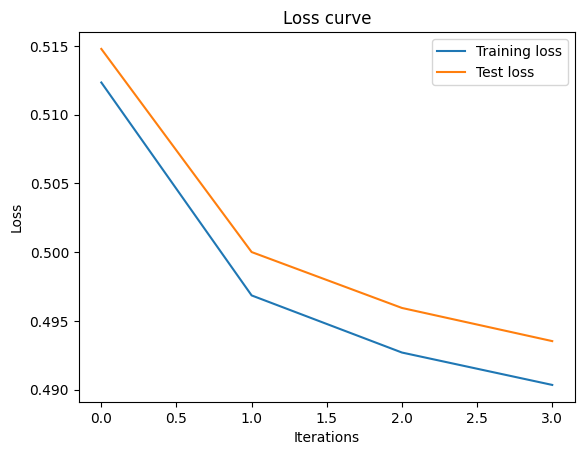

Iteration 5, loss = 0.48985401


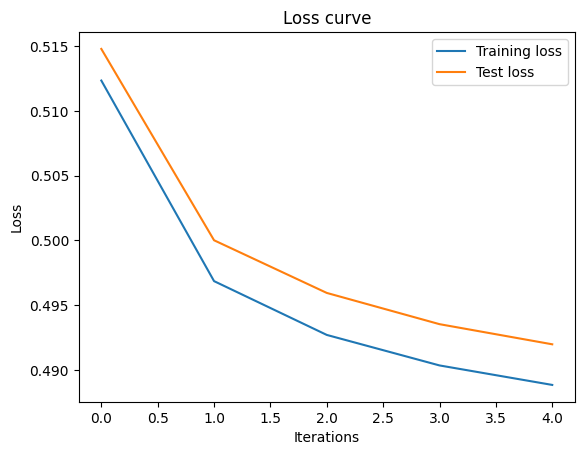

Iteration 6, loss = 0.48862938


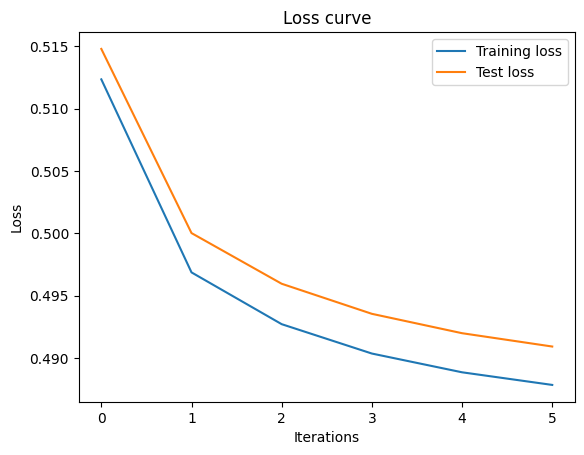

Iteration 7, loss = 0.48779307


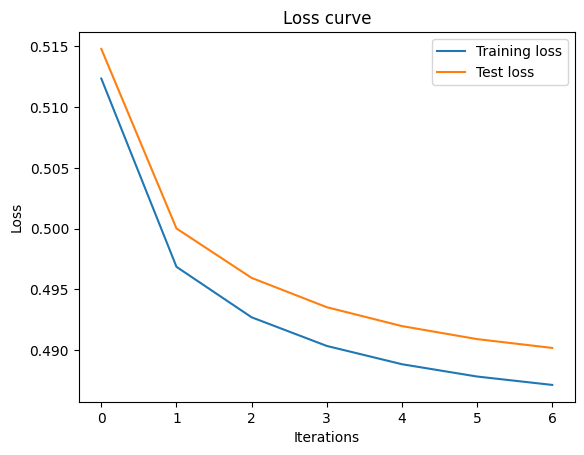

Iteration 8, loss = 0.48719507


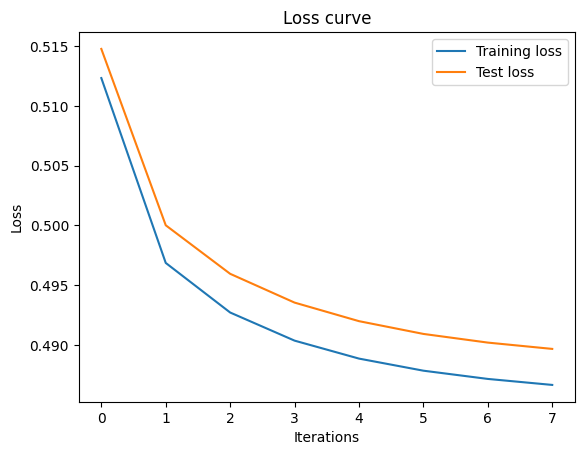

Iteration 9, loss = 0.48674371


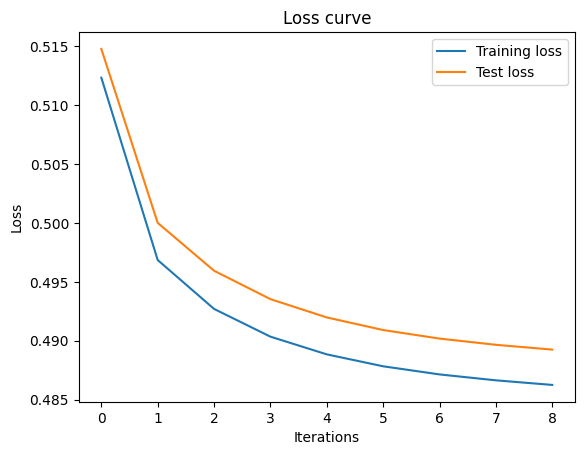

Iteration 10, loss = 0.48637116


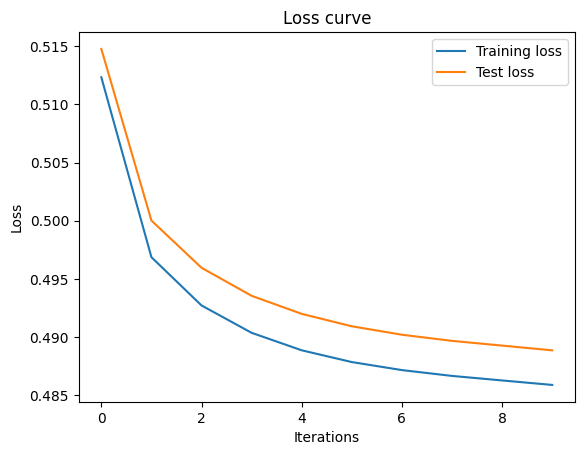

Iteration 11, loss = 0.48587634


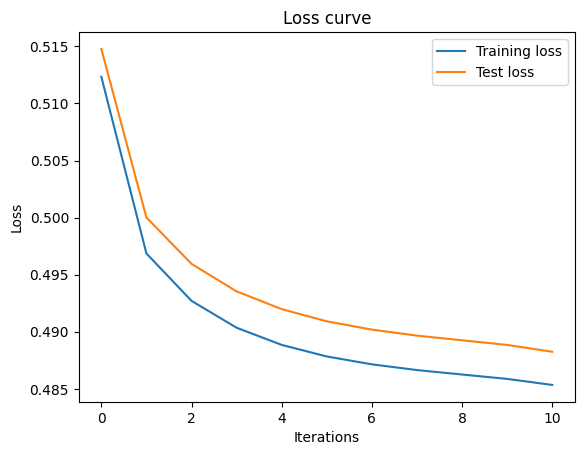

Iteration 12, loss = 0.48530250


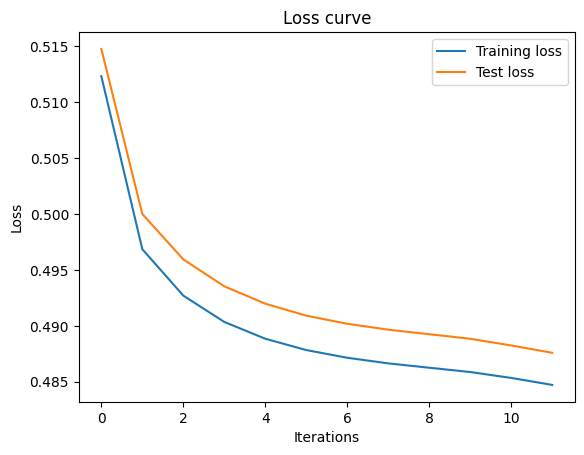

Iteration 13, loss = 0.48460313


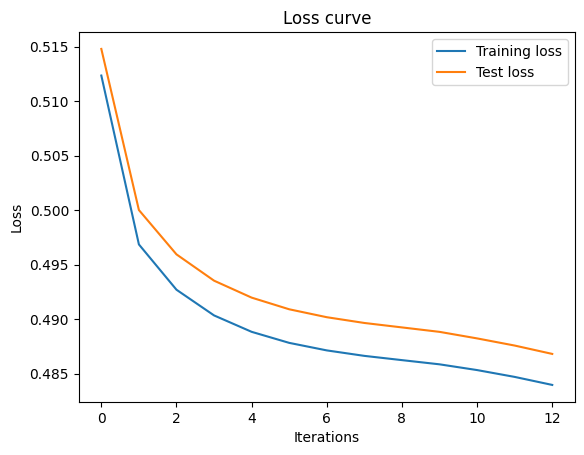

Iteration 14, loss = 0.48382947


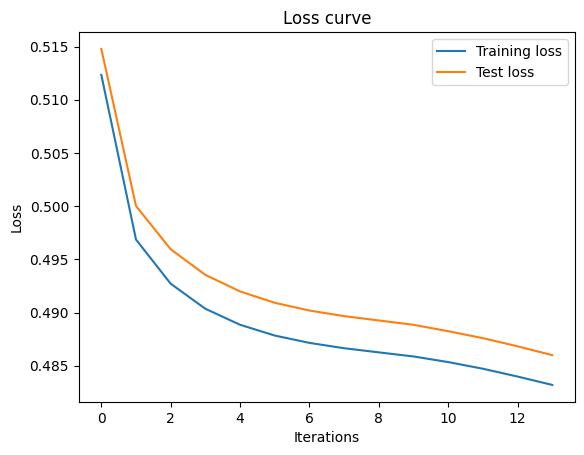

Iteration 15, loss = 0.48292372


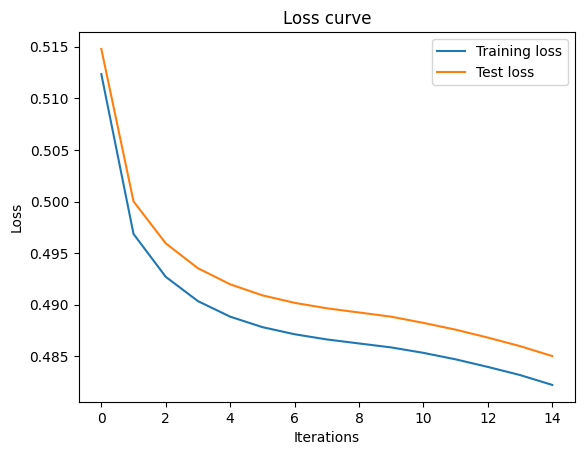

Iteration 16, loss = 0.48190387


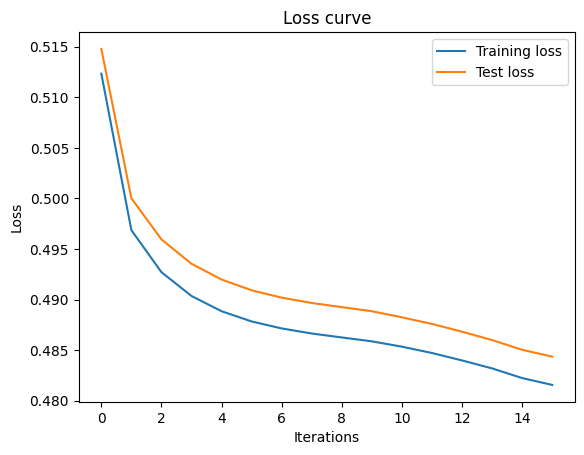

Iteration 17, loss = 0.48129158


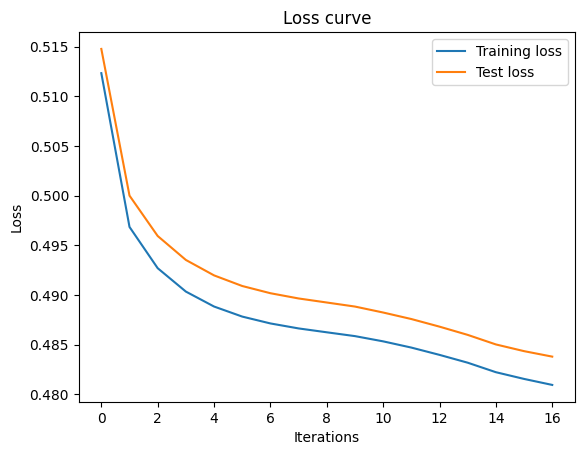

Iteration 18, loss = 0.48095536


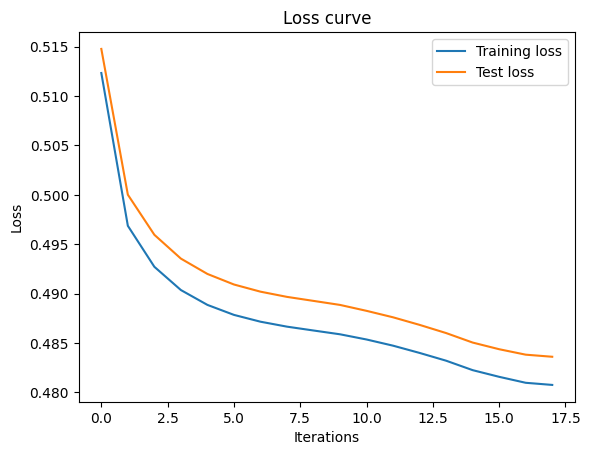

Iteration 19, loss = 0.48071054


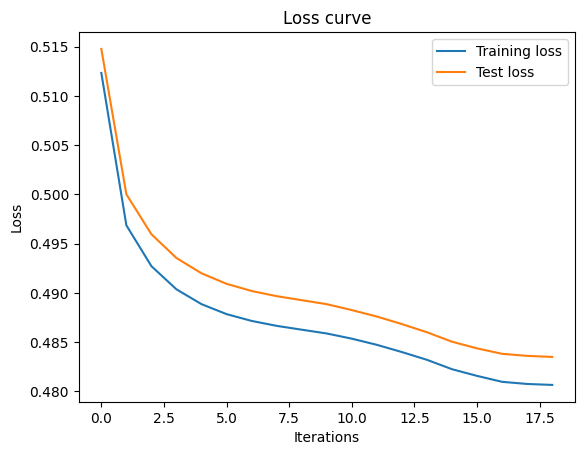

Iteration 20, loss = 0.48053600


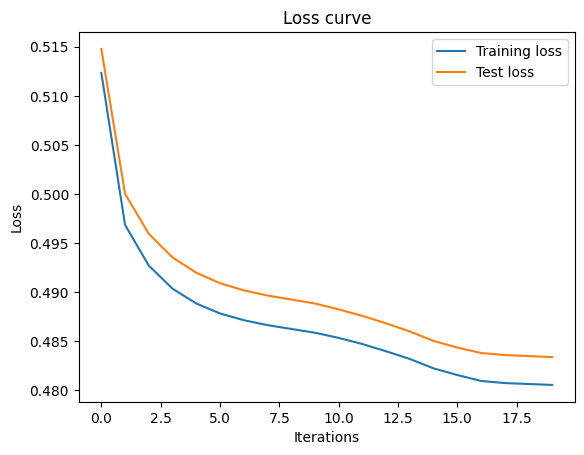

Iteration 21, loss = 0.48041337


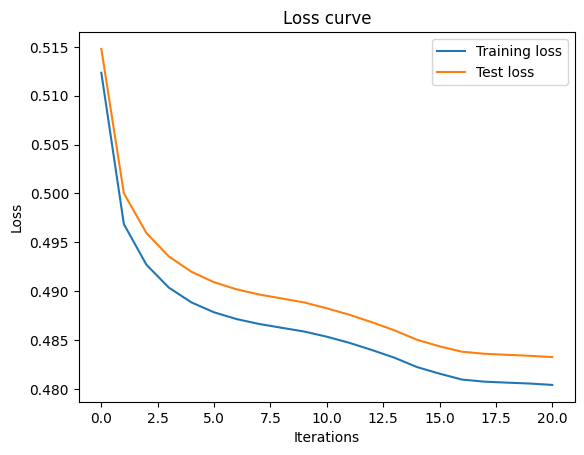

Iteration 22, loss = 0.48029096


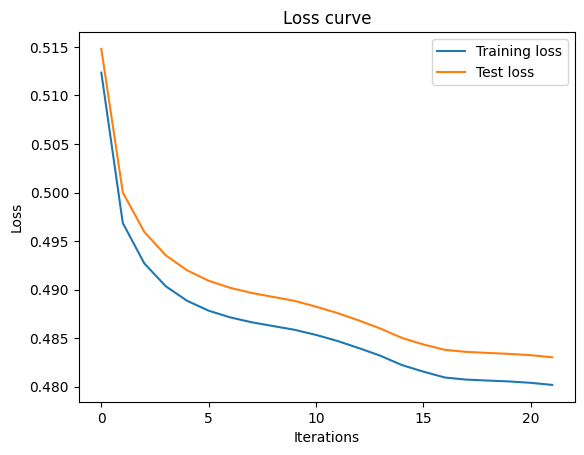

Iteration 23, loss = 0.48010638


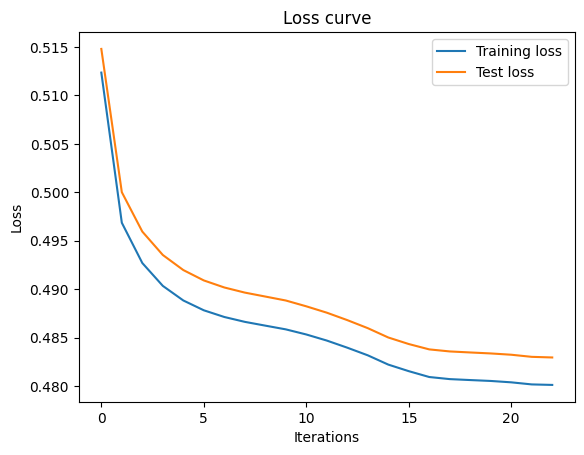

Iteration 24, loss = 0.48001387


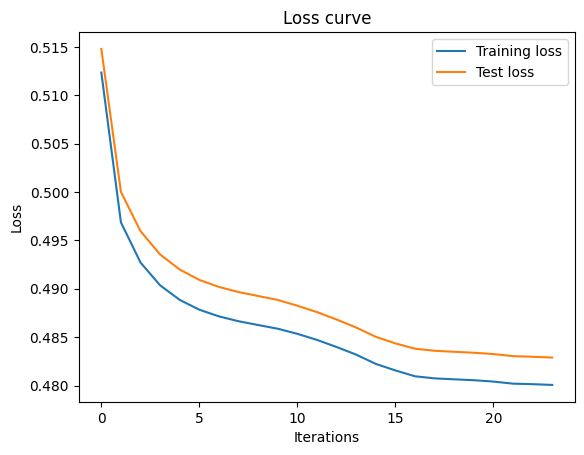

Iteration 25, loss = 0.47995473


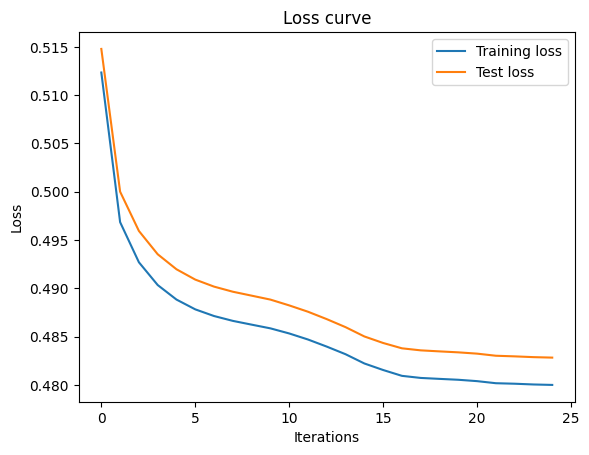

Iteration 26, loss = 0.47990706


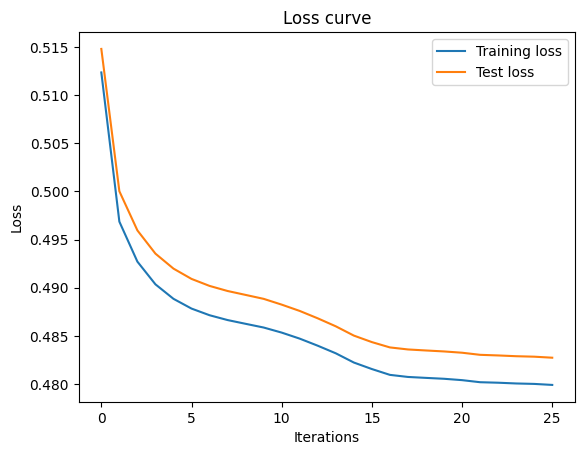

Iteration 27, loss = 0.47986206


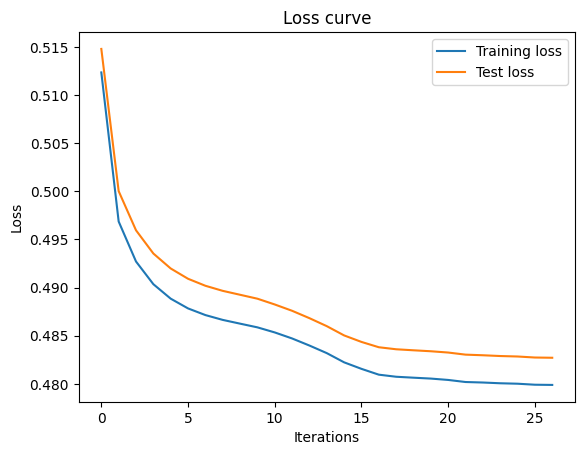

Iteration 28, loss = 0.47980709


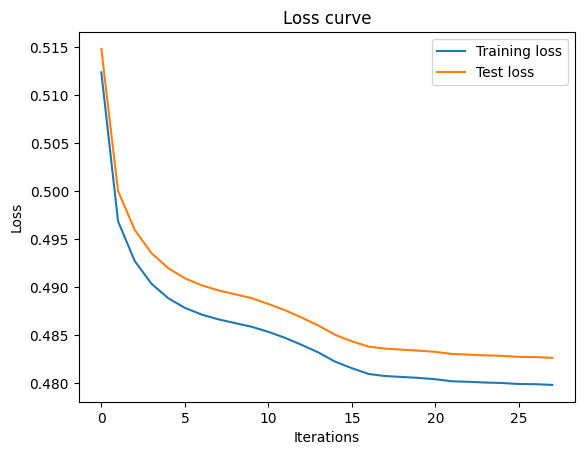

Iteration 29, loss = 0.47975650


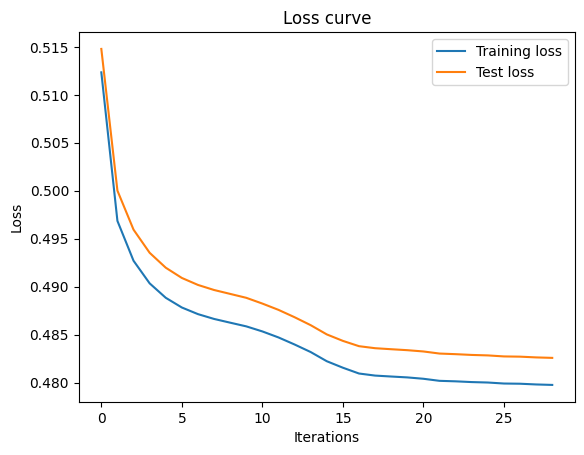

Iteration 30, loss = 0.47970020


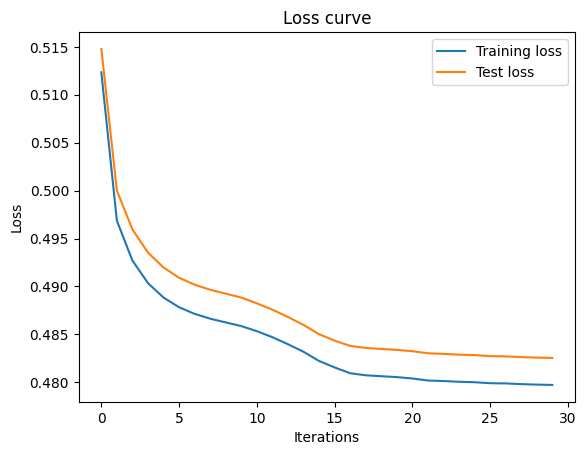

In [15]:
def gen_predictions(train_df, test_df):
    train = train_df.copy()
    test = test_df.copy()
    gdf = gpd.read_file('./geodata/mou/mou-c005-s010-vw-pr.geojson')

    tt_df = append_test_train(test, train)
    tt_df = tt_df[tt_df['Division'] == 'Chittagong']
    tt_df.info()
    tt_df['lon'], tt_df['lat'] = gen_centroids(tt_df, gdf)
    tt_df = tt_df.drop(
        columns=[
            'Division',
            'District',
            'Union',
            'Upazila',
            'Mouza'
        ]
    )
    
    print('==========')
    tt_df.info()
    test, train = split_test_train(tt_df)

    conv_cat_num(train, 'Label')
    conv_cat_num(test, 'Label')

    cat_int_enc(train)
    cat_int_enc(test)

    stratify(test)
    stratify(train)
    
    tt_df = ohe_col(tt_df, ['lat'])
    tt_df = ohe_col(tt_df, ['lon'])
    tt_df.info()
    

    train_X = train.drop(['Arsenic', 'Label'], axis='columns')
    train_y = train['Label']

    test_X = test.drop(['Arsenic', 'Label'], axis='columns')

    tt_df = append_test_train(test, train)
    cat_int_enc(tt_df)
    tt_df = pd.DataFrame(MinMaxScaler().fit_transform(tt_df), columns=tt_df.columns)

    te_div, tr_div = split_test_train(tt_df)

    X_train = tr_div.drop(
        ['Arsenic', 'Label', 'Prediction', 'Strata'], 
        axis='columns',
        errors='ignore'
    )

    y_train = tr_div['Label']
    X_test = te_div.drop(
        ['Arsenic', 'Label', 'Strata'],
        axis='columns'
    )
    y_test = te_div['Label']

    clf = MLPClassifier(
        solver='adam',
        alpha=0.0001,
        hidden_layer_sizes=(50, 2),
        learning_rate='adaptive',
        random_state=99,
        max_iter=30,
        verbose=True,
        validation_fraction=0.5,
    )

    test_loss = []
    train_loss = []
    for i in range(clf.max_iter):
        # train
        clf.partial_fit(X_train, y_train, classes=np.unique(y_train))
        y_train_pred = clf.predict_proba(X_train)
        train_loss.append(log_loss(y_train, y_train_pred))

        # test
        y_test_pred = clf.predict_proba(X_test)
        test_loss.append(log_loss(y_test, y_test_pred))
        
        plt.plot(train_loss, label='Training loss')
        plt.plot(test_loss, label='Test loss')
        plt.title('Loss curve')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

def m9_clf(
  test_src='./well_data/k1.csv',
  k_fold=1,
):
    train_df = load_k_train(k_fold)
    test_df = pd.read_csv(test_src) 

    train_df['Label'] = gen_labels(train_df)
    test_df['Label'] = gen_labels(test_df)

    gen_predictions(train_df, test_df)

m9_clf()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207420 entries, 2 to 173719
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Division  207420 non-null  object 
 1   District  207420 non-null  object 
 2   Upazila   207420 non-null  object 
 3   Union     207420 non-null  object 
 4   Mouza     207420 non-null  object 
 5   Depth     207420 non-null  float64
 6   Arsenic   207420 non-null  float64
 7   Label     207420 non-null  object 
 8   tid       207420 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 15.8+ MB


/tmp/ipykernel_123752/2589200396.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/tmp/ipykernel_123752/2589200396.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


<class 'pandas.core.frame.DataFrame'>
Int64Index: 207420 entries, 2 to 173719
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Depth    207420 non-null  float64
 1   Arsenic  207420 non-null  float64
 2   Label    207420 non-null  object 
 3   tid      207420 non-null  int64  
 4   lon      207420 non-null  float64
 5   lat      207420 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 11.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 207420 entries, 2 to 173719
Columns: 4860 entries, Depth to lon_92.25137599882451
dtypes: float64(2), int64(1), object(1), uint8(4856)
memory usage: 968.5+ MB
Iteration 1, loss = 0.48888435


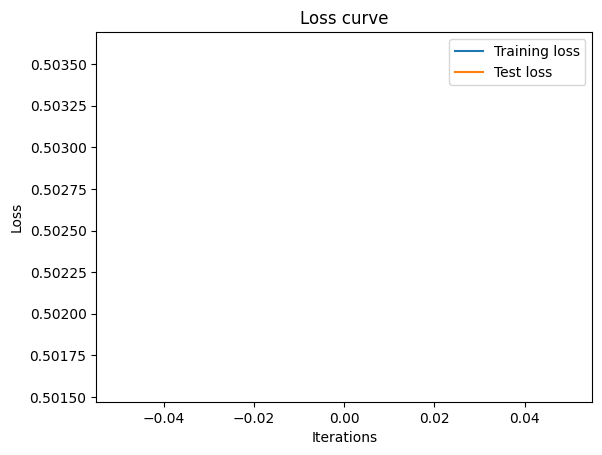

Iteration 2, loss = 0.48242946


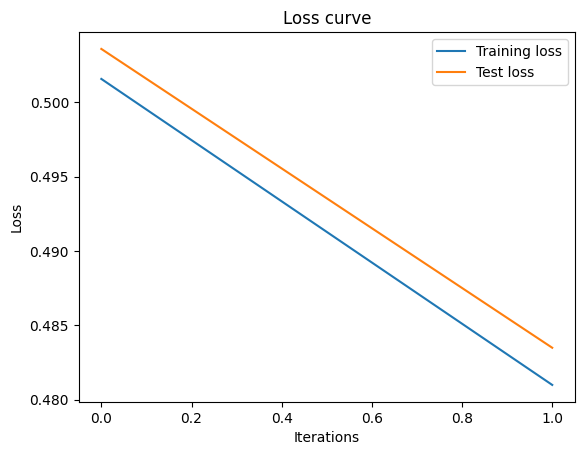

Iteration 3, loss = 0.48132006


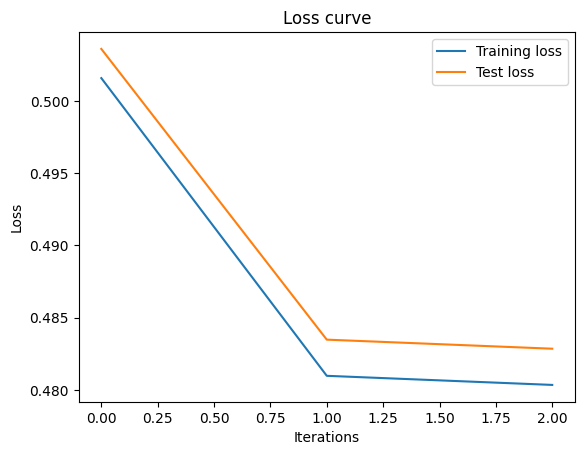

Iteration 4, loss = 0.48086832


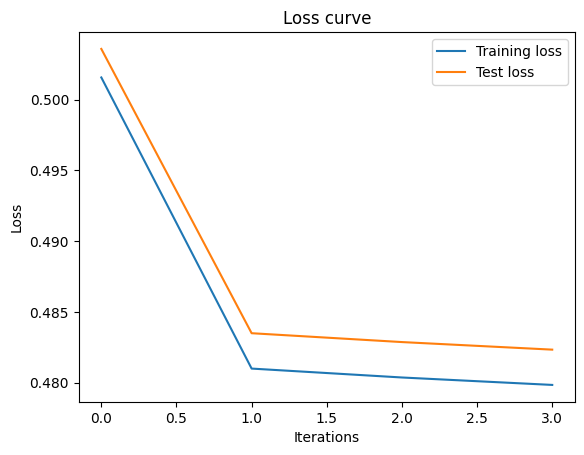

Iteration 5, loss = 0.48043663


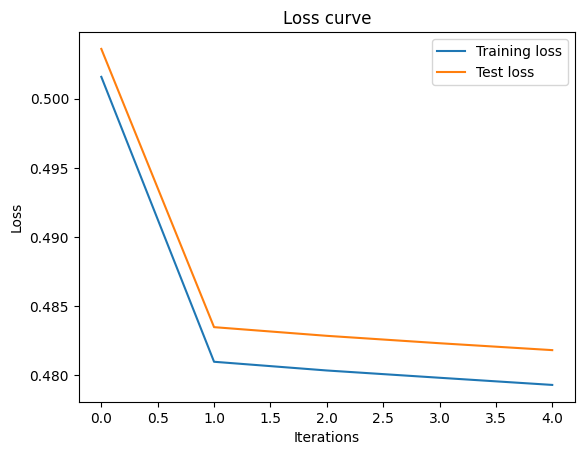

Iteration 6, loss = 0.48005740


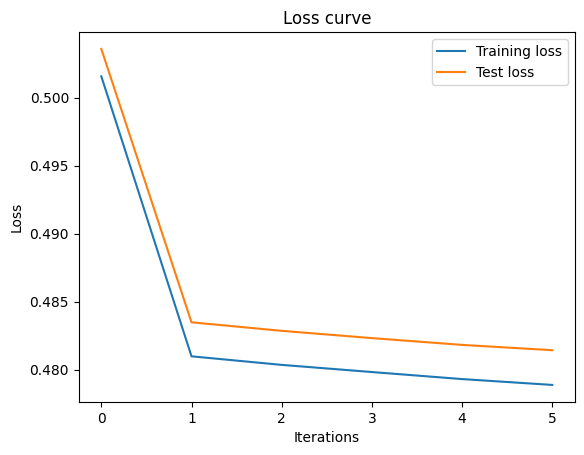

Iteration 7, loss = 0.47970565


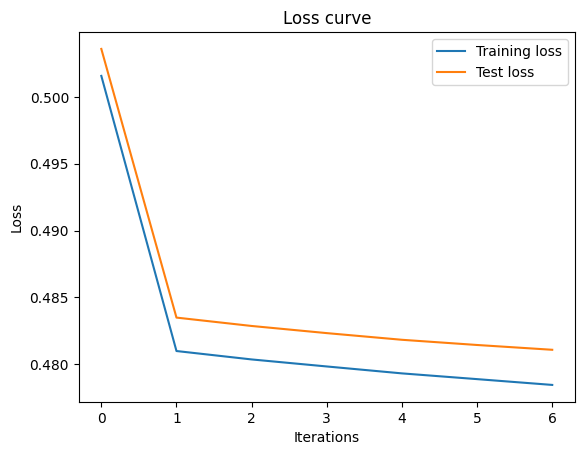

Iteration 8, loss = 0.47939419


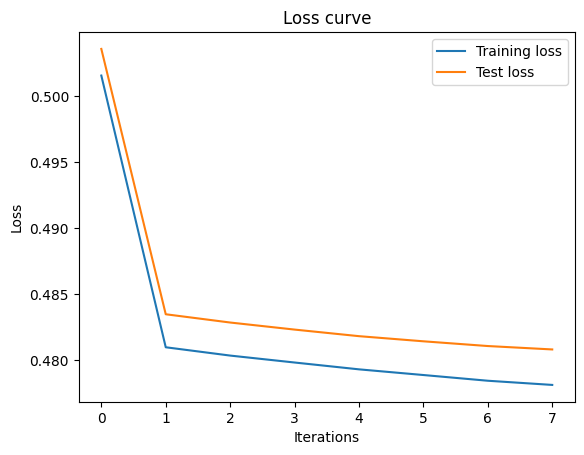

Iteration 9, loss = 0.47908126


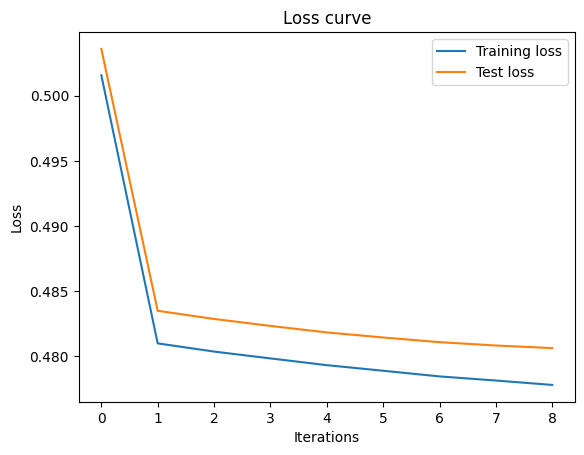

Iteration 10, loss = 0.47878414


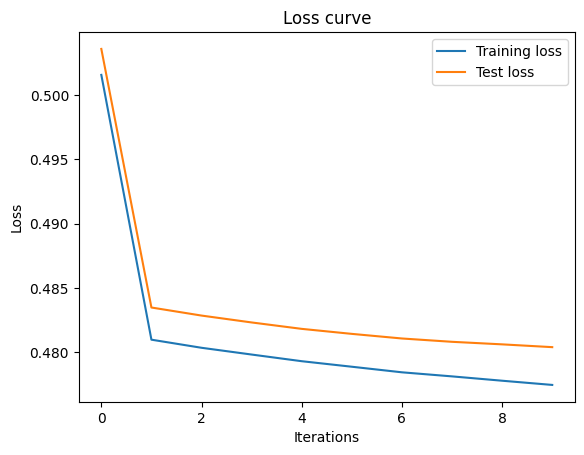

Iteration 11, loss = 0.47855106


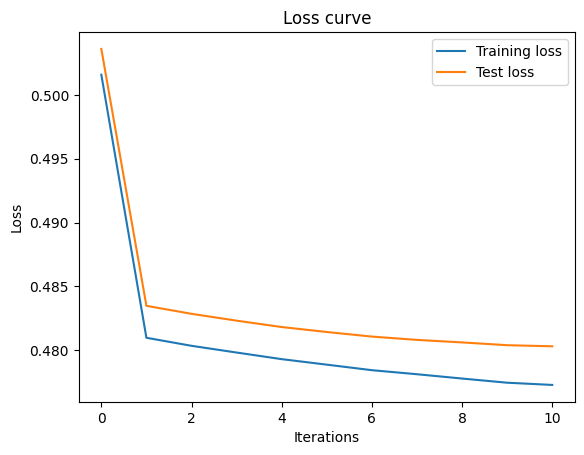

Iteration 12, loss = 0.47837886


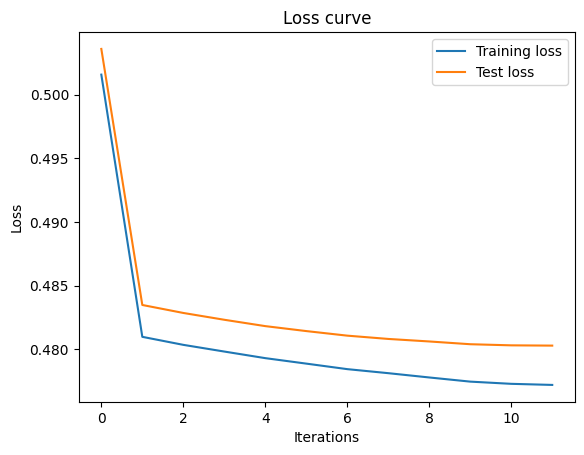

Iteration 13, loss = 0.47822885


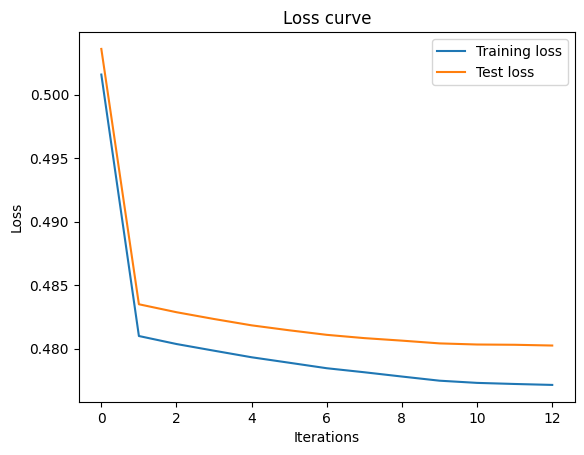

Iteration 14, loss = 0.47810251


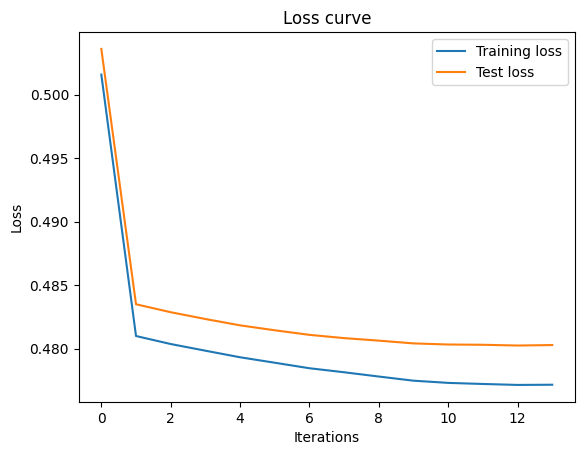

Iteration 15, loss = 0.47800691


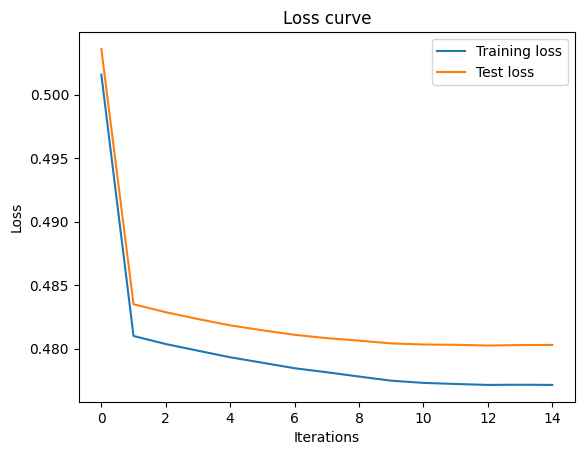

Iteration 16, loss = 0.47789391


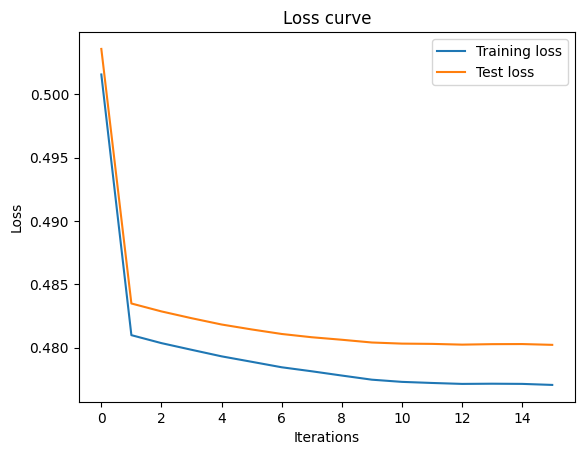

Iteration 17, loss = 0.47778941


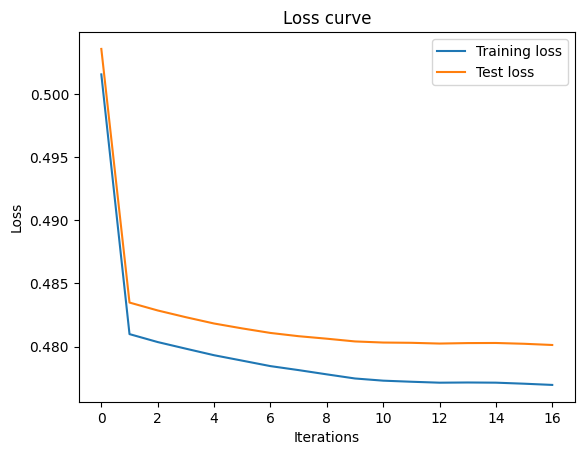

Iteration 18, loss = 0.47766148


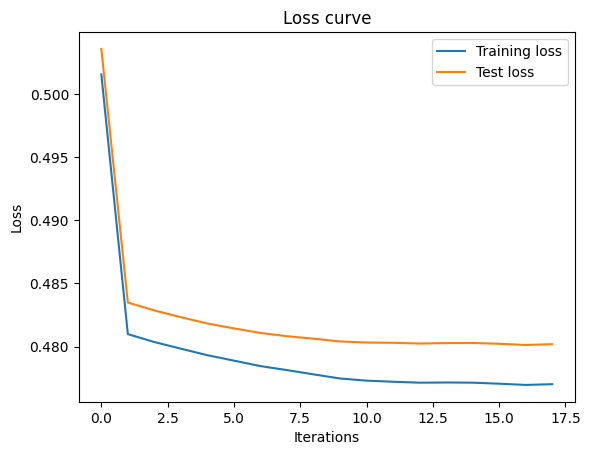

Iteration 19, loss = 0.47749367


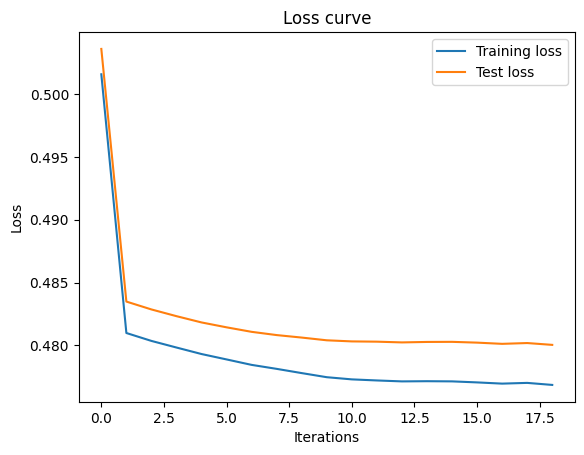

Iteration 20, loss = 0.47730485


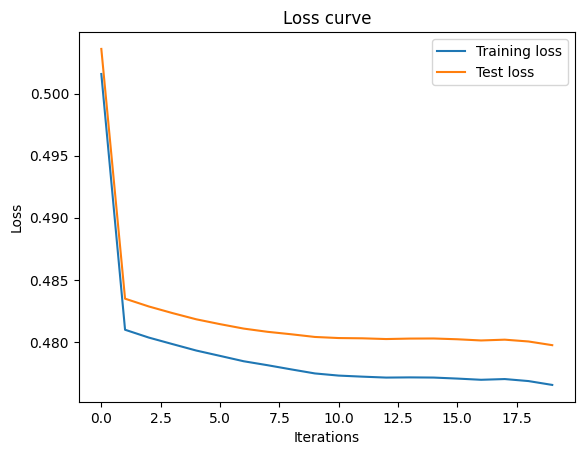

Iteration 21, loss = 0.47709257


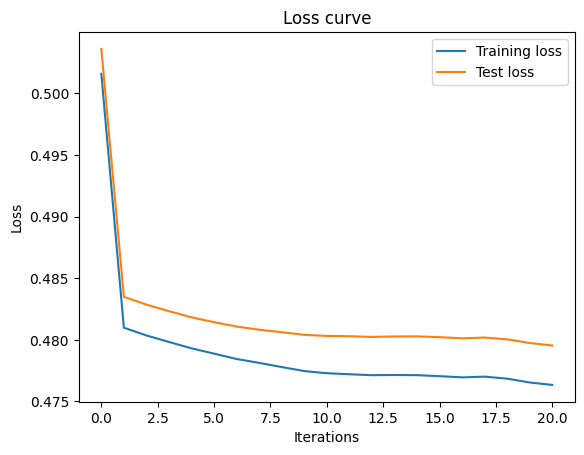

Iteration 22, loss = 0.47690006


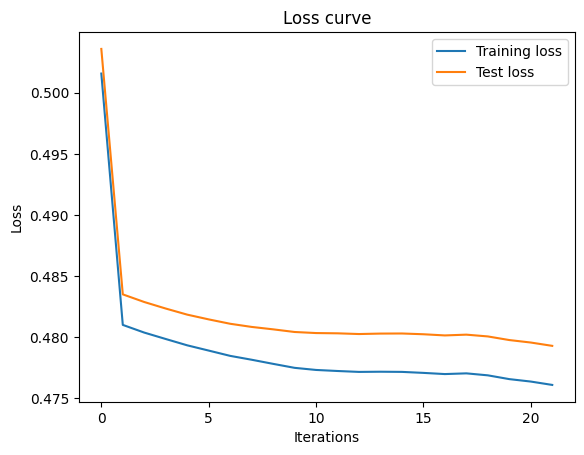

Iteration 23, loss = 0.47666844


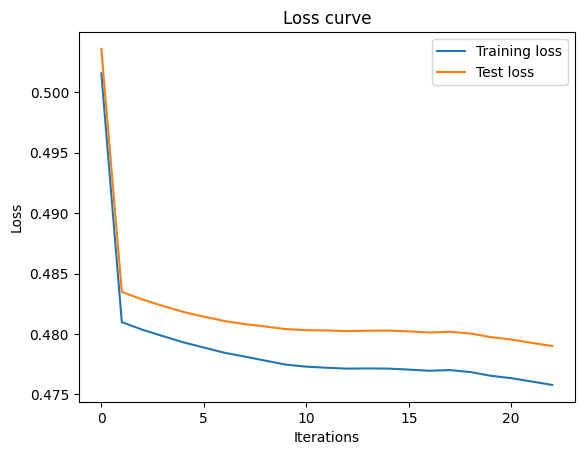

Iteration 24, loss = 0.47642905


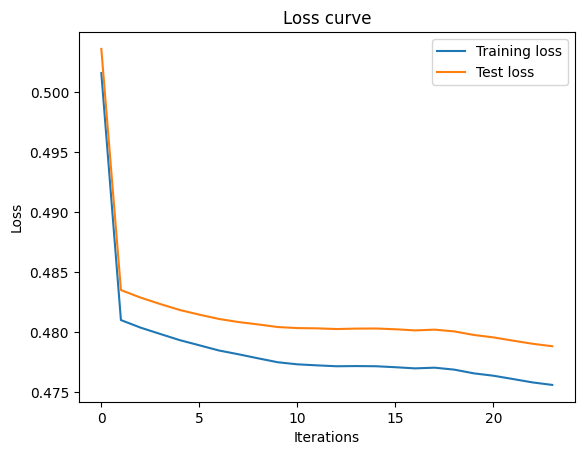

Iteration 25, loss = 0.47618770


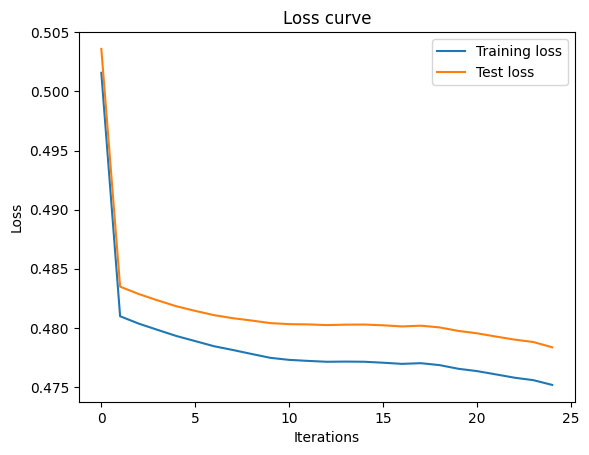

Iteration 26, loss = 0.47595714


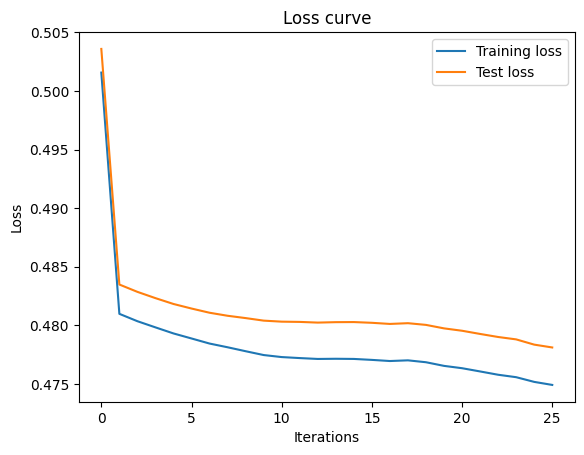

Iteration 27, loss = 0.47572216


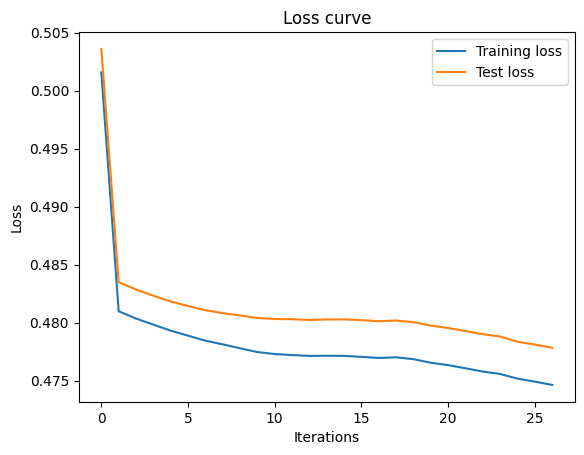

Iteration 28, loss = 0.47549094


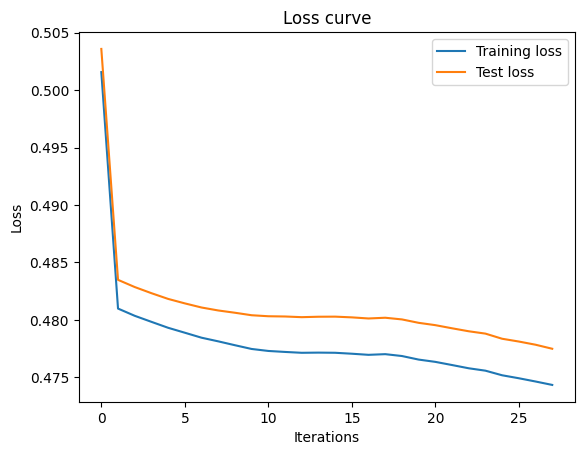

Iteration 29, loss = 0.47527681


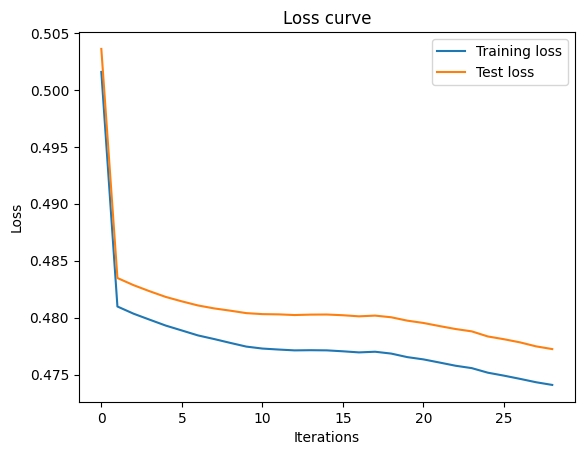

Iteration 30, loss = 0.47506984


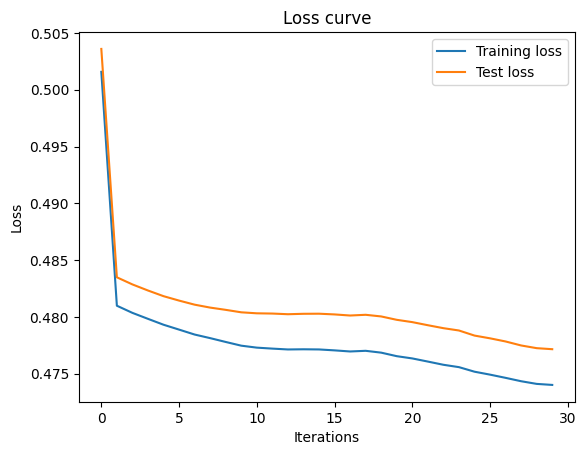

In [17]:
def gen_predictions(train_df, test_df):
    train = train_df.copy()
    test = test_df.copy()
    gdf = gpd.read_file('./geodata/mou/mou-c005-s010-vw-pr.geojson')

    tt_df = append_test_train(test, train)
    tt_df = tt_df[tt_df['Division'] == 'Chittagong']
    tt_df.info()
    tt_df['lon'], tt_df['lat'] = gen_centroids(tt_df, gdf)
    tt_df = tt_df.drop(
        columns=[
            'Division',
            'District',
            'Union',
            'Upazila',
            'Mouza'
        ]
    )
    
    print('==========')
    tt_df.info()
    test, train = split_test_train(tt_df)

    conv_cat_num(train, 'Label')
    conv_cat_num(test, 'Label')

    cat_int_enc(train)
    cat_int_enc(test)

    stratify(test)
    stratify(train)
    
    tt_df = ohe_col(tt_df, ['lat'])
    tt_df = ohe_col(tt_df, ['lon'])
    tt_df.info()
    

    train_X = train.drop(['Arsenic', 'Label'], axis='columns')
    train_y = train['Label']

    test_X = test.drop(['Arsenic', 'Label'], axis='columns')

    tt_df = append_test_train(test, train)
    cat_int_enc(tt_df)
    tt_df = pd.DataFrame(MinMaxScaler().fit_transform(tt_df), columns=tt_df.columns)

    te_div, tr_div = split_test_train(tt_df)

    X_train = tr_div.drop(
        ['Arsenic', 'Label', 'Prediction', 'Strata'], 
        axis='columns',
        errors='ignore'
    )

    y_train = tr_div['Label']
    X_test = te_div.drop(
        ['Arsenic', 'Label', 'Strata'],
        axis='columns'
    )
    y_test = te_div['Label']

    clf = MLPClassifier(
        solver='adam',
        alpha=0.0001,
        hidden_layer_sizes=(500, 250),
        learning_rate='adaptive',
        random_state=99,
        max_iter=30,
        verbose=True,
        validation_fraction=0.5,
    )

    test_loss = []
    train_loss = []
    for i in range(clf.max_iter):
        # train
        clf.partial_fit(X_train, y_train, classes=np.unique(y_train))
        y_train_pred = clf.predict_proba(X_train)
        train_loss.append(log_loss(y_train, y_train_pred))

        # test
        y_test_pred = clf.predict_proba(X_test)
        test_loss.append(log_loss(y_test, y_test_pred))
        
        plt.plot(train_loss, label='Training loss')
        plt.plot(test_loss, label='Test loss')
        plt.title('Loss curve')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

def m9_bigger_clf(
  test_src='./well_data/k1.csv',
  k_fold=1,
):
    train_df = load_k_train(k_fold)
    test_df = pd.read_csv(test_src) 

    train_df['Label'] = gen_labels(train_df)
    test_df['Label'] = gen_labels(test_df)

    gen_predictions(train_df, test_df)

m9_bigger_clf()

In [ ]:
def gen_predictions(train_df, test_df):
    train = train_df.copy()
    test = test_df.copy()
    gdf = gpd.read_file('./geodata/mou/mou-c005-s010-vw-pr.geojson')

    tt_df = append_test_train(test, train)
    tt_df = tt_df[tt_df['Division'] == 'Chittagong']
    tt_df.info()
    tt_df['lon'], tt_df['lat'] = gen_centroids(tt_df, gdf)
    tt_df = tt_df.drop(
        columns=[
            'Division',
            'District',
            'Union',
            'Upazila',
            'Mouza'
        ]
    )
    
    print('==========')
    tt_df.info()
    test, train = split_test_train(tt_df)

    conv_cat_num(train, 'Label')
    conv_cat_num(test, 'Label')

    cat_int_enc(train)
    cat_int_enc(test)

    stratify(test)
    stratify(train)
    
    tt_df = ohe_col(tt_df, ['lat'])
    tt_df = ohe_col(tt_df, ['lon'])
    tt_df.info()
    

    train_X = train.drop(['Arsenic', 'Label'], axis='columns')
    train_y = train['Label']

    test_X = test.drop(['Arsenic', 'Label'], axis='columns')

    tt_df = append_test_train(test, train)
    cat_int_enc(tt_df)
    tt_df = pd.DataFrame(MinMaxScaler().fit_transform(tt_df), columns=tt_df.columns)

    te_div, tr_div = split_test_train(tt_df)

    X_train = tr_div.drop(
        ['Arsenic', 'Label', 'Prediction', 'Strata'], 
        axis='columns',
        errors='ignore'
    )

    y_train = tr_div['Label']
    X_test = te_div.drop(
        ['Arsenic', 'Label', 'Strata'],
        axis='columns'
    )
    y_test = te_div['Label']

    clf = MLPClassifier(
        solver='adam',
        alpha=0.0001,
        hidden_layer_sizes=(2000, 1000, 100),
        learning_rate='adaptive',
        random_state=99,
        max_iter=100,
        verbose=True,
    )

    test_loss = []
    train_loss = []
    for i in range(clf.max_iter):
        # train
        clf.partial_fit(X_train, y_train, classes=np.unique(y_train))
        y_train_pred = clf.predict_proba(X_train)
        train_loss.append(log_loss(y_train, y_train_pred))

        # test
        y_test_pred = clf.predict_proba(X_test)
        test_loss.append(log_loss(y_test, y_test_pred))

        plt.plot(train_loss, label='Training loss')
        plt.plot(test_loss, label='Test loss')
        plt.title('Loss curve')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

def big_clf_100iter(
  test_src='./well_data/k1.csv',
  k_fold=1,
):
    train_df = load_k_train(k_fold)
    test_df = pd.read_csv(test_src) 

    train_df['Label'] = gen_labels(train_df)
    test_df['Label'] = gen_labels(test_df)

    gen_predictions(train_df, test_df)

big_clf_100iter()